In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
base_dir = r"
]"
image_size = 224

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [4]:
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 70295 images belonging to 38 classes.


In [5]:
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 17572 images belonging to 38 classes.


In [6]:
train_data.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [7]:
train_data.image_shape

(224, 224, 3)

In [8]:
# include_top=False (Do not include the ImageNet classifier at the top)

base_model = keras.applications.MobileNet(weights="imagenet",
                                          input_shape=(224,224,3),
                                          include_top=False,)

17235968/17225924 [==============================] - 4s 0us/step


In [9]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [10]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense((38),activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name='leaf_disease_model_mobilenet')
mobilenet_model.summary()

Model: "leaf_disease_model_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 38)                38950     
                                                                 
Total params: 3,267,814
Trainable para

In [11]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import EarlyStopping

# EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1)

callbacks_list = [early_stop]

history = mobilenet_model.fit(train_data,
                              steps_per_epoch=300,  
                              validation_data=test_data,
                              epochs=7,
                              validation_steps=300,
                              callbacks=callbacks_list)

Epoch 1/7
300/300 [==============================] - 1771s 6s/step - loss: 0.2322 - categorical_accuracy: 0.9266 - val_loss: 0.1692 - val_categorical_accuracy: 0.9443
Epoch 2/7
300/300 [==============================] - 1713s 6s/step - loss: 0.2251 - categorical_accuracy: 0.9268 - val_loss: 0.1523 - val_categorical_accuracy: 0.9513
Epoch 3/7
300/300 [==============================] - 1765s 6s/step - loss: 0.2305 - categorical_accuracy: 0.9251 - val_loss: 0.1642 - val_categorical_accuracy: 0.9451
Epoch 4/7
300/300 [==============================] - 1714s 6s/step - loss: 0.2033 - categorical_accuracy: 0.9326 - val_loss: 0.1539 - val_categorical_accuracy: 0.9469
Epoch 5/7
300/300 [==============================] - 9147s 31s/step - loss: 0.2138 - categorical_accuracy: 0.9293 - val_loss: 0.1354 - val_categorical_accuracy: 0.9540
Epoch 6/7
300/300 [==============================] - 1788s 6s/step - loss: 0.2033 - categorical_accuracy: 0.9309 - val_loss: 0.1417 - val_categorical_accuracy: 0.95

In [15]:
mobilenet_model.evaluate(test_data)

550/550 [==============================] - 538s 978ms/step - loss: 0.1634 - categorical_accuracy: 0.9432


[0.1634206771850586, 0.9432051181793213]

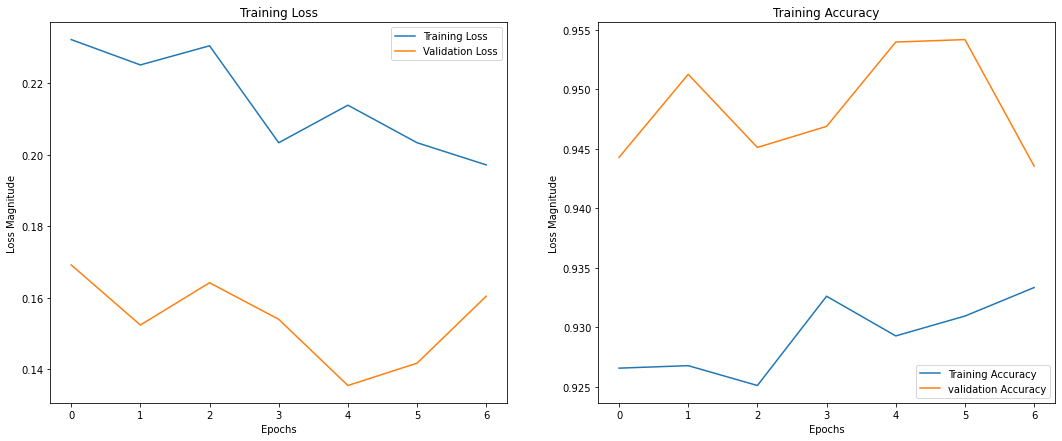

In [16]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation Accuracy')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Accuracy')
plt.legend(loc='lower right')
plt.show()